In [1]:
import pandas as pd
import zipfile
import os
import sys
from datetime import datetime
from datetime import timedelta
import numpy as np
pd.set_option('display.max_columns', 500)

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d')
vars_serg = ["estadoOrden","Ciudad","Departamento",
             "stado_producto","Marca","Pasillo","Categoria",
             "ProductoEnPromocion","cantidadVendida",
             "TotalPagado","Domicilio","PrecioFinal",
             "FechaCreaciónOrden"]

In [4]:
vars_group_b = ["FechaCreaciónOrden",
                'month_year',
                "Ciudad",
                "Departamento",
                "estadoOrden",
                "stado_producto",
                "Marca",
                "Pasillo",
                "Categoria",
                "ProductoEnPromocion"]

In [5]:
df_p = pd.read_csv("../Data/MERQ_CONS",
                      usecols=vars_serg,
                      encoding='latin1',
                     dtype={'estadoOrden' : str,
                            'TotalPagado' : np.float64,
                            "Domicilio" : str,
                            "FechaCreaciónOrden" : str,
                            "FechaProgramaciónOrden" : str,
                            "FechadeEntregaOrden" : str,
                            "Ciudad" : str,
                            "fechacreacionProducto" : str,
                            "stado_producto" : str,
                            "Marca" : str,
                            "Departamento" : str,
                            "Pasillo" : str,
                            "Categoria" : str,
                            "ProductoEnPromocion" : np.float64,
                            "cantidadVendida" : np.float64,
                            "PrecioFinal": np.float64})

In [6]:
df_p = df_p.dropna()
df_p = df_p[(df_p.cantidadVendida>0) & 
            (df_p.TotalPagado>0)]
df_p["cuenta_gr"] = [1]*df_p.shape[0]
df_p['FechaCreaciónOrden'] = pd.to_datetime(df_p.FechaCreaciónOrden)
df_p['month_year'] = df_p.FechaCreaciónOrden.apply(lambda x: "%d-%d" % (x.year,x.month))
df_p.set_index("FechaCreaciónOrden",inplace=True,drop=False)

In [7]:
df_p.sort_values("FechaCreaciónOrden",inplace=True)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 'FechaCreaciónOrden' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  """Entry point for launching an IPython kernel.


In [8]:
df_p.columns

Index(['estadoOrden', 'TotalPagado', 'Domicilio', 'FechaCreaciónOrden',
       'Ciudad', 'stado_producto', 'Marca', 'Departamento', 'Pasillo',
       'Categoria', 'cantidadVendida', 'ProductoEnPromocion', 'PrecioFinal',
       'cuenta_gr', 'month_year'],
      dtype='object')

In [9]:
from math import ceil

def week_of_month(dt):
    """ Returns the week of the month for the specified date.
    """

    first_day = dt.replace(day=1)

    dom = dt.day
    adjusted_dom = dom + first_day.weekday()

    return str(int(ceil(adjusted_dom/7.0)))

In [10]:
serie = df_p[["FechaCreaciónOrden","Pasillo","Ciudad","TotalPagado","cuenta_gr","cantidadVendida"]].groupby(["FechaCreaciónOrden","Pasillo","Ciudad"],
                                                                                  as_index=False).sum()

serie.set_index("FechaCreaciónOrden",inplace=True,drop=False)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 'FechaCreaciónOrden' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  


In [11]:
serie["Month"] = serie.FechaCreaciónOrden.apply(lambda x: "%d" % x.month)
serie["year"] = serie.FechaCreaciónOrden.apply(lambda x: "%d" % x.year)
serie["week"] = serie.FechaCreaciónOrden.apply(week_of_month)


In [12]:
caegorias_selected = serie.groupby("Pasillo").sum().sort_values("cantidadVendida",ascending=False)

In [13]:
caegorias_selected = caegorias_selected[caegorias_selected.cantidadVendida>60000]
caegorias_selected = caegorias_selected.index.tolist()

In [165]:
caegorias_selected

['Leches',
 'Bebidas Lácteas',
 'Huevos',
 'Granos',
 'Tortas y postres',
 'Panes',
 'Galletas',
 'Cuidado de la ropa',
 'Frutas',
 'Sal, salsas y condimentos',
 'Azúcar y endulzantes',
 'Pastas',
 'Cocina',
 'Verduras',
 'Enlatados y conservas',
 'Quesos',
 'Cereales',
 'Aseo general',
 'Baño',
 'Harinas y mezclas listas',
 'Chocolate y té',
 'Aceites y aderezos',
 'Pollo',
 'Cremas',
 'Pasabocas',
 'Arepas',
 'Implementos de limpieza',
 'Jamón y mortadela',
 'Jugos y néctares',
 'Salchichas',
 'Mantequillas y margarinas',
 'Caldos, sopas y cremas',
 'Cuidado corporal',
 'Aguas']

In [14]:
serie[serie.Pasillo.isin(caegorias_selected)].cuenta_gr.sum()/serie.cuenta_gr.sum()

0.82928403463230993

In [15]:
serie = serie[serie.Pasillo.isin(caegorias_selected)]

In [16]:
serie["split_index"] = np.arange(0,len(serie))

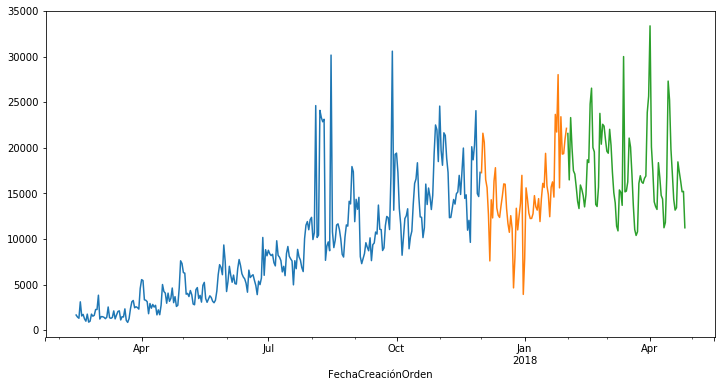

In [17]:
a = serie[(serie.Pasillo.isin(caegorias_selected))].cantidadVendida.resample("D").sum()
plt.figure(figsize=(12,6))
a[:'2017-11'].plot()
a['2017-12':'2018-01'].plot()
a['2018-02':].plot()

In [18]:
y1 = a[:'2017-11'].values
y2 = a['2017-12':'2018-01'].values
y3 = a['2018-02':].values

In [19]:
n_bins=np.linspace(0, max(max(y1),max(y2),max(y3)), 25)

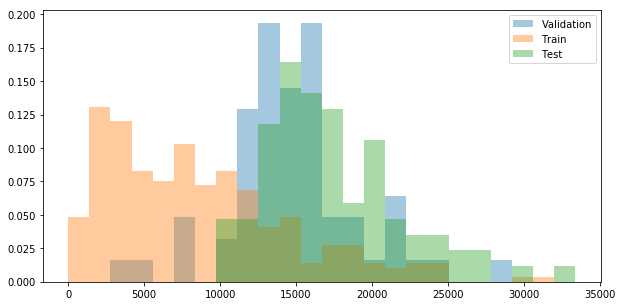

In [20]:
## gCompare
plt.figure(figsize=(10,5))
sns.distplot(y2, kde=False,bins=n_bins,
             hist_kws={'weights': np.full(len(y2), 1/len(y2)),
                       'label':"Validation"})
sns.distplot(y1, kde=False,bins=n_bins,
             hist_kws={'weights': np.full(len(y1), 1/len(y1)),
                       'label':"Train"})
sns.distplot(y3, kde=False,bins=n_bins,
             hist_kws={'weights': np.full(len(y3), 1/len(y3)),
                       'label':"Test"})
plt.legend()
plt.show()

In [21]:
y1.shape,y2.shape

((291,), (62,))

In [22]:
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf

In [23]:
# acf_y1, ci, Q, pvalue = acf(y1, nlags=4,qstat=True,alpha=.05,unbiased=True)

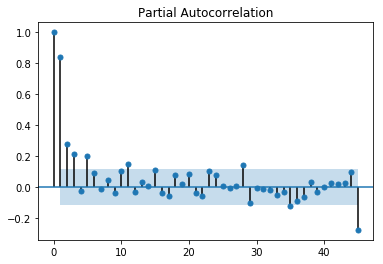

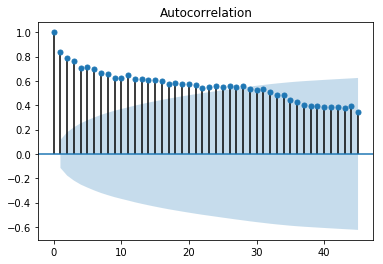

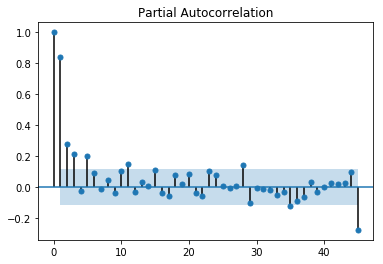

In [24]:
plot_acf(y1,alpha=0.05,lags=45)
plot_pacf(y1,alpha=0.05,lags=45)

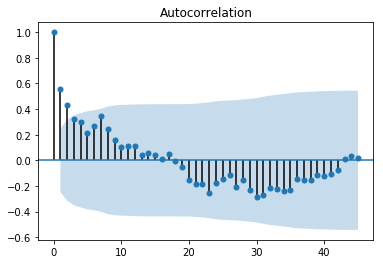

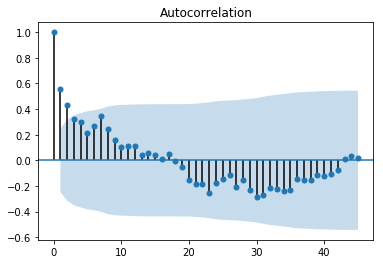

In [25]:
plot_acf(y2,alpha=0.05,lags=45)

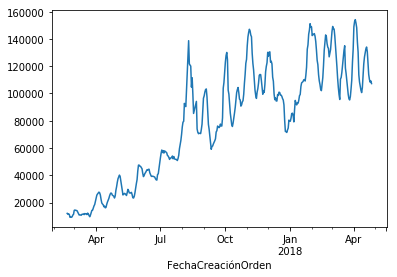

In [26]:
# a.plot()
a.rolling(window=7).sum().plot()

In [27]:
serie.cuenta_gr.sum()

3808370

In [28]:
serie.head()

,FechaCreaciónOrden,Pasillo,Ciudad,TotalPagado,cuenta_gr,cantidadVendida,Month,year,week,split_index
FechaCreaciónOrden,,,,,,,,,,
2017-02-13,2017-02-13,Aceites y aderezos,Bogotá,2052996.0,19,20.0,2,2017,3,0
2017-02-13,2017-02-13,Aguas,Bogotá,227546.0,5,8.0,2,2017,3,1
2017-02-13,2017-02-13,Arepas,Bogotá,589900.0,9,9.0,2,2017,3,2
2017-02-13,2017-02-13,Aseo general,Bogotá,2605300.0,24,28.0,2,2017,3,3
2017-02-13,2017-02-13,Azúcar y endulzantes,Bogotá,2249050.0,34,46.0,2,2017,3,4


In [29]:
serie.dtypes

FechaCreaciónOrden    datetime64[ns]
Pasillo                       object
Ciudad                        object
TotalPagado                  float64
cuenta_gr                      int64
cantidadVendida              float64
Month                         object
year                          object
week                          object
split_index                    int64
dtype: object

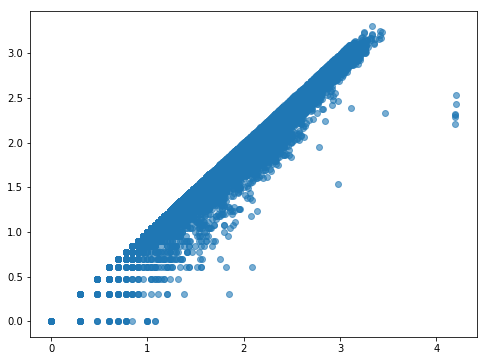

In [235]:
plt.figure(figsize=(8,6))
plt.scatter(np.log10(serie.cantidadVendida),
        np.log10(serie.cuenta_gr),
            alpha = 0.6)

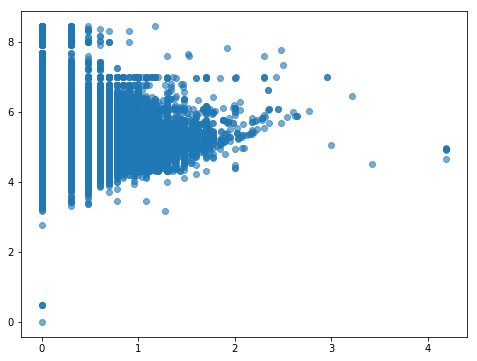

In [31]:
plt.figure(figsize=(8,6))
plt.scatter(np.log10(df_p.cantidadVendida),
        np.log10(df_p.TotalPagado),
            alpha = 0.6)

In [32]:
serie.dtypes

FechaCreaciónOrden    datetime64[ns]
Pasillo                       object
Ciudad                        object
TotalPagado                  float64
cuenta_gr                      int64
cantidadVendida              float64
Month                         object
year                          object
week                          object
split_index                    int64
dtype: object

In [234]:
serie.head()

,FechaCreaciónOrden,Pasillo,Ciudad,TotalPagado,cuenta_gr,cantidadVendida,Month,year,week,split_index,interval_count_orders,day_name
FechaCreaciónOrden,,,,,,,,,,,,
2017-02-13,2017-02-13,Aceites y aderezos,Bogotá,2052996.0,19,20.0,2,2017,3,0,"(0, 25]",Monday
2017-02-13,2017-02-13,Aguas,Bogotá,227546.0,5,8.0,2,2017,3,1,"(0, 25]",Monday
2017-02-13,2017-02-13,Arepas,Bogotá,589900.0,9,9.0,2,2017,3,2,"(0, 25]",Monday
2017-02-13,2017-02-13,Aseo general,Bogotá,2605300.0,24,28.0,2,2017,3,3,"(0, 25]",Monday
2017-02-13,2017-02-13,Azúcar y endulzantes,Bogotá,2249050.0,34,46.0,2,2017,3,4,"(25, 50]",Monday


In [463]:
serie.logTotalPagado.describe()

count    24303.000000
mean         7.039074
std          0.581402
min          4.302980
25%          6.623933
50%          7.052980
75%          7.483927
max          9.864896
Name: logTotalPagado, dtype: float64

In [290]:
serie["interval_count_orders"] = pd.cut(serie.cuenta_gr,bins=list(range(0,200,25))+[500,max(serie.cuenta_gr)])

In [291]:
serie["day_name"] = serie.FechaCreaciónOrden.apply(lambda x: "%s" % x.weekday_name)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: `weekday_name` is deprecated and will be removed in a future version. Use `day_name` instead
  """Entry point for launching an IPython kernel.


In [362]:
serie["logTotalPagado"] = np.log10(serie.TotalPagado)
serie["logcuentagr"] = np.log10(serie.cuenta_gr)

In [447]:
def get_feat_y(df):
    dum = pd.get_dummies(df[["Pasillo","Ciudad","Month","week","day_name"]],drop_first=True)
    print(dum.shape)
    X = pd.concat([df[["logTotalPagado","logcuentagr"]],dum],axis=1)
    mat_corr = X.corr()
    x_scl = scaler.fit_transform(X)
    Y = df.cantidadVendida.values
    val_names = X.columns.tolist()
    return {'X':x_scl,'Y':Y,
            'colnames':val_names,
            'mat_corr':mat_corr}

In [448]:
serie.shape

(24303, 14)

In [449]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_index = serie[:'2017-11']["split_index"].values
val_index = serie['2017-12':'2018-01']["split_index"].values
test_index = serie['2018-02':]["split_index"].values
df_mod = get_feat_y(serie)

(24303, 56)


In [378]:
X_train = df_mod["X"][train_index]
Y_train = df_mod["Y"][train_index]

X_val = df_mod["X"][val_index]
Y_val = df_mod["Y"][val_index]

X_test = df_mod["X"][test_index]
Y_test = df_mod["Y"][test_index]

In [379]:
X_train.shape,X_val.shape,X_test.shape

((14310, 58), (4213, 58), (5780, 58))

In [380]:
df_mod.keys()

dict_keys(['X', 'Y', 'colnames', 'mat_corr'])

In [381]:
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV

In [382]:
sc_tree = tree.DecisionTreeRegressor(criterion="mae",random_state=29,min_samples_split=0.05)

In [383]:
param_search = {'max_depth' : [3,5,7,10]}

In [392]:
my_cv = TimeSeriesSplit(n_splits=5).split(X_train,Y_train)
gsearch = GridSearchCV(estimator=sc_tree, cv=my_cv,
                       param_grid=param_search,
                       n_jobs=6,
                       verbose=1)

In [393]:
gsearch.fit(X_train,Y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:   23.4s finished


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7f152374bc50>,
       error_score='raise',
       estimator=DecisionTreeRegressor(criterion='mae', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=0.05, min_weight_fraction_leaf=0.0,
           presort=False, random_state=29, splitter='best'),
       fit_params=None, iid=True, n_jobs=6,
       param_grid={'max_depth': [3, 5, 7, 10]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=1)

In [394]:
mae_val = metrics.mean_absolute_error(gsearch.best_estimator_.predict(X_val),
                            Y_val)
mae_test = metrics.mean_absolute_error(gsearch.best_estimator_.predict(X_test),
                            Y_test)

print("%f MAE on validation dataset\n%f MAE on test dataset" % (mae_val,mae_test))

28.701756 MAE on validation dataset
39.250865 MAE on test dataset


In [395]:
gsearch.best_estimator_

DecisionTreeRegressor(criterion='mae', max_depth=10, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=0.05, min_weight_fraction_leaf=0.0,
           presort=False, random_state=29, splitter='best')

In [396]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
# dot_data = StringIO()
# export_graphviz(clf, out_file=dot_data,  
#                 filled=True, rounded=True,
#                 special_characters=True)
# graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
# graph.write_pdf("tree.pdf")

In [397]:
with open("DT_classifier.txt", "w") as f:
    f = export_graphviz(gsearch.best_estimator_,out_file=f,feature_names=df_mod["colnames"])


## Random forest

In [450]:
from sklearn.ensemble import RandomForestRegressor

In [454]:
RF_tree = RandomForestRegressor(criterion="mae",random_state=95,n_jobs=-1)

In [455]:
X_train.shape

(14310, 58)

In [456]:
param_search = dict(n_estimators=[10],
                    max_depth=[10,70,80],
                    bootstrap=['True'])

In [457]:
my_cv = TimeSeriesSplit(n_splits=10).split(X_train,Y_train)
gsearch = GridSearchCV(estimator=RF_tree, cv=my_cv,
                       param_grid=param_search,
                       n_jobs=6,
                       verbose=1)
gsearch.fit(X_train,Y_train)

In [459]:
mae_val = metrics.mean_absolute_error(gsearch.best_estimator_.predict(X_val),
                            Y_val)
mae_test = metrics.mean_absolute_error(gsearch.best_estimator_.predict(X_test),
                            Y_test)

print("%f MAE on test dataset\n%f MAE on validation dataset" % (mae_test,mae_val))

20.429022 MAE on test dataset
16.806183 MAE on validation dataset


In [460]:
gsearch.best_estimator_

RandomForestRegressor(bootstrap='True', criterion='mae', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=95, verbose=0, warm_start=False)

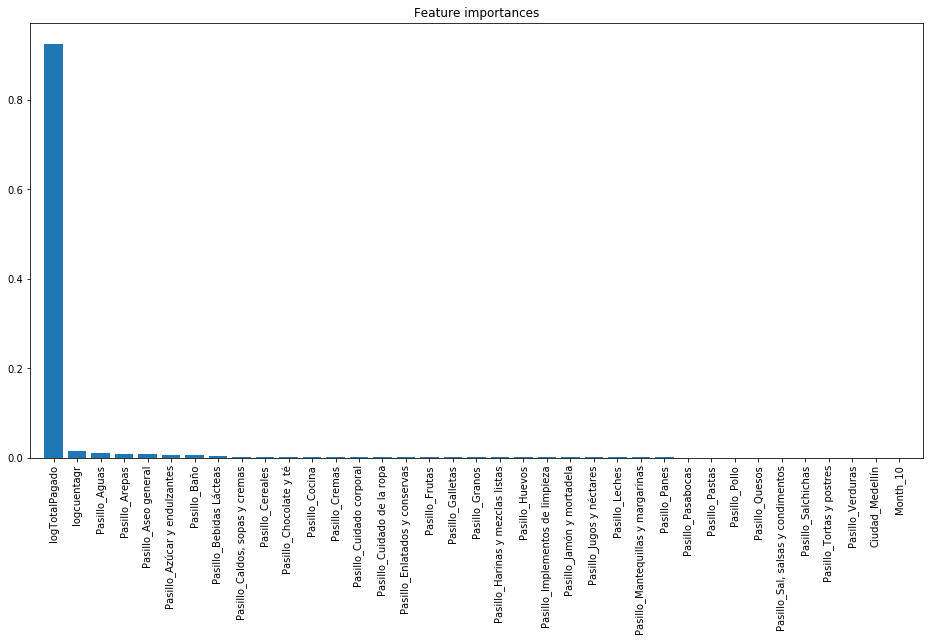

In [461]:
#######################################################################################
# feature importances
#Find out the most important features
importances = gsearch.best_estimator_.feature_importances_
indices_sub = np.argsort(importances)[:20:-1]

# Plot the feature importances of the forest
plt.figure(figsize=(16,8))
plt.title("Feature importances")
plt.bar(range(X_train[:,indices_sub].shape[1]), importances[indices_sub], align="center")
plt.xticks(range(X_train[:,indices_sub].shape[1]),df_mod['colnames'],rotation=90)
plt.xlim([-1, X_train[:,indices_sub].shape[1]])
# plt.savefig(os.path.join('/home/juan/Desktop/Fast_Mode_sebs/FastMode','img','Feature_Importances_xgb.png'),
#             format = 'png',
#             dpi=300,bbox_inches = 'tight')
plt.show()


In [466]:


my_cv = TimeSeriesSplit(n_splits=10).split(X_train[:,indices_sub],Y_train)
gsearch = GridSearchCV(estimator=RF_tree, cv=my_cv,
                       param_grid=param_search,
                       n_jobs=6,
                       verbose=1)
gsearch.fit(X_train[:,indices_sub],Y_train)

Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:  1.2min finished


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7f152380f150>,
       error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=95, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=6,
       param_grid={'n_estimators': [10], 'max_depth': [10, 70, 80], 'bootstrap': ['True']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [468]:
mae_val = metrics.mean_absolute_error(gsearch.best_estimator_.predict(X_val[:,indices_sub]),
                            Y_val)
mae_test = metrics.mean_absolute_error(gsearch.best_estimator_.predict(X_test[:,indices_sub]),
                            Y_test)

print("%f MAE on test dataset\n%f MAE on validation dataset" % (mae_test,mae_val))

20.402561 MAE on test dataset
16.758996 MAE on validation dataset


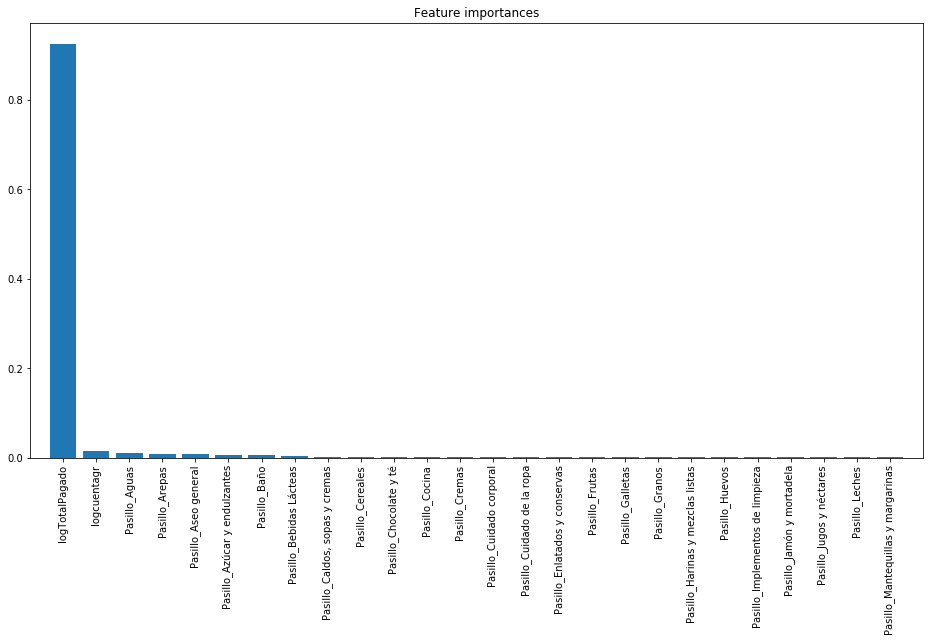

In [470]:
#######################################################################################
# feature importances
#Find out the most important features
importances = gsearch.best_estimator_.feature_importances_
indices_sub = np.argsort(importances)[:10:-1]

# Plot the feature importances of the forest
plt.figure(figsize=(16,8))
plt.title("Feature importances")
plt.bar(range(X_train[:,indices_sub].shape[1]), importances[indices_sub], align="center")
plt.xticks(range(X_train[:,indices_sub].shape[1]),df_mod['colnames'],rotation=90)
plt.xlim([-1, X_train[:,indices_sub].shape[1]])
# plt.savefig(os.path.join('/home/juan/Desktop/Fast_Mode_sebs/FastMode','img','Feature_Importances_xgb.png'),
#             format = 'png',
#             dpi=300,bbox_inches = 'tight')
plt.show()